In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Load data

In [4]:
# population allele frequencies
true_pop_allele_freq = np.load('../data/true_pop_allele_freq.npy')

# individual admixtures
true_ind_admix_propn = np.load('../data/true_ind_admix_propn.npy')

# observations 
g_obs = np.load('../data/simulated_genotypes.npy')

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_pop = true_pop_allele_freq.shape[1]

print('true_number of populations: ', n_pop)

true_number of populations:  4


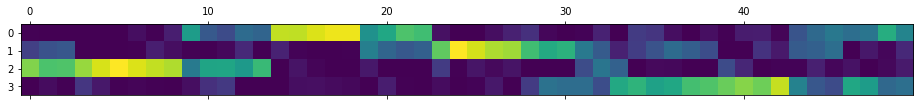

In [5]:
plt.matshow(true_ind_admix_propn.T)

# Load initial fit

In [8]:
alpha_vec = np.arange(1, 10)
for i in range(len(alpha_vec)): 
    init_alpha = alpha_vec[i]
    # load optimal vb parameters at init_alpha
    vb_opt_dict, vb_params_paragami, data =\
        paragami.load_folded('../fits/simulated_data_fit_alpha{}.npz'.format(init_alpha))

    # free optimal vb_parameters
    vb_opt_free_params = vb_params_paragami.flatten(vb_opt_dict, free = True)

    # load prior parameters
    prior_params_dict, prior_params_paragami = \
        structure_model_lib.get_default_prior_params()
    prior_params_dict['dp_prior_alpha'] = data['alpha']

    # other parameters
    gh_deg = int(data['gh_deg'])
    gh_loc, gh_weights = hermgauss(gh_deg)

    # assert we are at an optimum 
    structure_model_lib.assert_optimizer(g_obs, vb_opt_dict, vb_params_paragami, 
                                         prior_params_dict, gh_loc, gh_weights)
    
    print('getting lr object at alpha = {}'.format(init_alpha))
    
    get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])
    
    vb_sens = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights),
            opt_par_value = vb_opt_free_params, 
            hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
            validate_optimum=False,
            hessian_at_opt=None,
            cross_hess_at_opt=None,
            factorize_hessian=True,
            hyper_par_objective_fun=None,
            grad_tol=1e-8)
    
    np.save('../fits/hessian_at_alpha{}'.format(init_alpha), vb_sens._hess0)

getting lr object at alpha = 1
getting lr object at alpha = 2
getting lr object at alpha = 3
getting lr object at alpha = 4
getting lr object at alpha = 5
getting lr object at alpha = 6
getting lr object at alpha = 7
getting lr object at alpha = 8
getting lr object at alpha = 9
